<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/Clipping%20Raster%20In%20R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Clip Raster in R
#### https://www.earthdatascience.org/courses/earth-analytics/lidar-raster-data-r/crop-raster-data-in-r/

In [1]:
# load the raster and rgdal libraries
install.packages("raster")
install.packages("rgdal")
install.packages("googledrive")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘Rcpp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘rgdal’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# install.packages('sf')
# install.packages('exactextractr')
# install.packages("DBI")
# install.packages("RSQLite")
# install.packages("RPostgreSQL")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(ggplot2)
# library(sf)
library(magrittr)
library(data.table)
library(raster)
# library(exactextractr)
library(googledrive)
library(DBI)
library(zip)

Loading required package: sp


Attaching package: ‘zip’


The following objects are masked from ‘package:utils’:

    unzip, zip




In [3]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=039c5a53928887dc6602d819347edd3b&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbHBrMU9IRVZoWWlxcTBMbXU2YUZhNWZkUEFObUtRMnJIRkNLQmg5ZW9PT29yTF9pT0hRcnl3dWRBQVJtNHcxdyIsInN0YXRlIjoiMDM5YzVhNTM5Mjg4ODdkYzY2MDJkODE5MzQ3ZWRkM2IifQ==


In [4]:
dir.create('/content/2000')

In [5]:
# extract the data from drive and bring it to local memory
#  Island Path https://drive.google.com/file/d/1nq_qe7IVJF-SiRgC-ESfsMJUsTQTw1v5/view?usp=drive_link
drive_download(file = as_id('1nq_qe7IVJF-SiRgC-ESfsMJUsTQTw1v5'), path =  '/content/2000/Oahu', overwrite = FALSE)

File downloaded:

• Oahu_2000_elevation.tif <id: 1nq_qe7IVJF-SiRgC-ESfsMJUsTQTw1v5>

Saved locally as:

• /content/2000/Oahu



In [53]:
# # open raster layer
open_raster <- raster("/content/2000/Oahu")

In [54]:
open_raster

class      : RasterLayer 
band       : 1  (of  7  bands)
dimensions : 2088, 2750, 5742000  (nrow, ncol, ncell)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -158.3362, -157.595, 21.20114, 21.76384  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : Oahu 
names      : Blue 


In [57]:
nbands(open_raster)

[1] 7

In [59]:
open_raster <- stack('/content/2000/Oahu')

In [60]:
open_raster

class      : RasterStack 
dimensions : 2088, 2750, 5742000, 7  (nrow, ncol, ncell, nlayers)
resolution : 0.0002694946, 0.0002694946  (x, y)
extent     : -158.3362, -157.595, 21.20114, 21.76384  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : Blue, Green, Red, NIR, SWIR1, SWIR2, elevation 


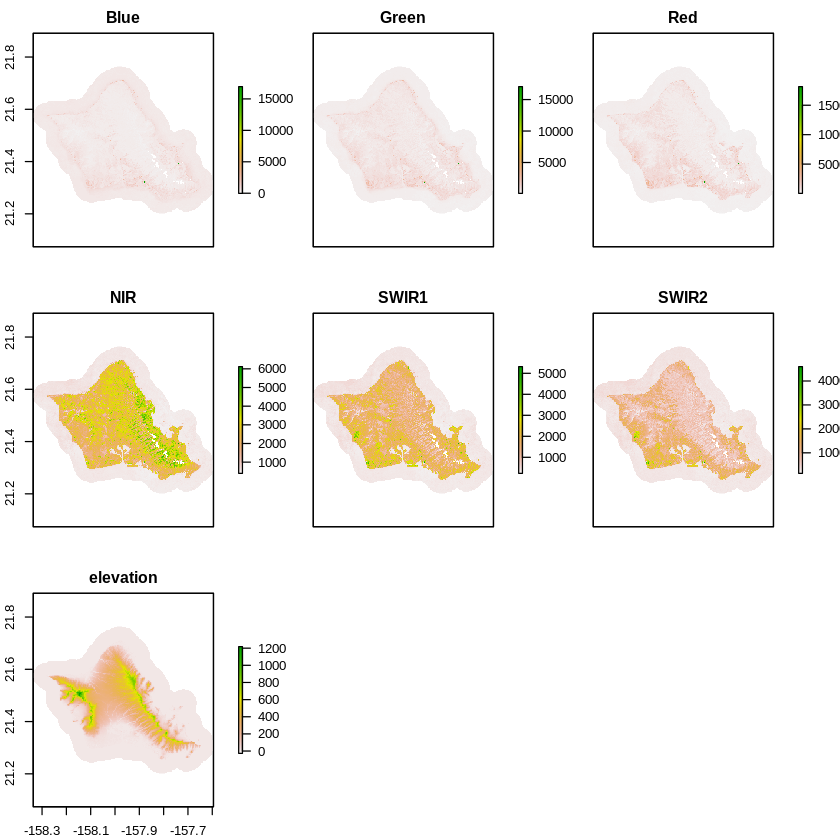

In [61]:
open_raster %>% plot

In [66]:
nrow(open_raster)
ncol(open_raster)
nlayers(open_raster)

dim(open_raster)

[1] 2088

[1] 2750

[1] 7

[1] 2088 2750    7

In [67]:
y_end <- c(seq(1,open_raster %>% nrow,512),nrow(open_raster))[-1]
x_end <- c(seq(1,open_raster %>% ncol,512),ncol(open_raster))[-1]

extract_grid <- expand.grid(x_end,y_end) %>% data.table

names(extract_grid) <- c('x_end','y_end')

extract_grid$x_org <- extract_grid$x_end - 512
extract_grid$y_org <- extract_grid$y_end - 512

extract_grid$id <- 1:nrow(extract_grid)

In [71]:
y_end
x_end

[1]  513 1025 1537 2049 2088

[1]  513 1025 1537 2049 2561 2750

In [75]:
# Specify the path for the new folder/directory
new_folder_path <- "/content/2000/Images"
# Use dir.create to create the new folder
dir.create(new_folder_path, showWarnings = FALSE)

# Check if the folder was created successfully
if (file.exists(new_folder_path)) {
  cat("Folder created:", new_folder_path, "\n")
} else {
  cat("Failed to create folder:", new_folder_path, "\n")
}

Folder created: /content/2000/Images 


In [77]:
result_dt <- 1:nrow(extract_grid) %>% lapply(function(x) {

  nrow <- 0
  ncol <- 0
  i <- 0
  while (nrow != 512 | ncol != 512) {
    i <- i + 1
    # Calculate the geographic coordinates for the cropping extent
    xmin <- xFromCol(open_raster, extract_grid[x,]$x_org) + rnorm(1) * 0.01 * 2.4
    xmax <- xFromCol(open_raster, extract_grid[x,]$x_end) + rnorm(1) * 0.01 * 2.4
    ymin <- yFromRow(open_raster, extract_grid[x,]$y_end) + rnorm(1) * 0.01 * 2.4
    ymax <- yFromRow(open_raster, extract_grid[x,]$y_org) + rnorm(1) * 0.01 * 2.4

    e <- extent(xmin, xmax, ymin, ymax)

    cropped_open_raster <- crop(open_raster, e)

    nrow <- nrow(cropped_open_raster)
    ncol <- ncol(cropped_open_raster)

    if (i > 1000) {
      return('failed to converge')
    }
  }

  # Define a filename for the exported image
  filename <- paste('/content/2000/Images/', extract_grid[x,]$x_org, '_', extract_grid[x,]$y_org, '.tif', sep = '')

  # Export the cropped part as a GeoTIFF image
  cropped_open_raster %>%
    writeRaster(., filename, overwrite = TRUE)

  return(NULL)  # No data.table is returned here

})

result_dt[ result_dt %>% lapply(function(x) { is.data.table(x) }) %>% unlist] %>% rbindlist %>%
  fwrite('/content/2000/Images.csv')


In [76]:
result_dt <-
1:nrow(extract_grid) %>% lapply(function(x){

  nrow <- 0
  ncol <- 0
  i <- 0
  while(nrow !=512 | ncol != 512){
    i <- i + 1
    # Calculate the geographic coordinates for the cropping extent
    xmin <- xFromCol(open_raster, extract_grid[x,]$x_org) + rnorm(1)*.01*2.4
    xmax <- xFromCol(open_raster, extract_grid[x,]$x_end) + rnorm(1)*.01*2.4
    ymin <- yFromRow(open_raster, extract_grid[x,]$y_end) + rnorm(1)*.01*2.4 # Note row_max as raster origin is top-left
    ymax <- yFromRow(open_raster, extract_grid[x,]$y_org) + rnorm(1)*.01*2.4 # Note row_min as raster origin is top-left

    e <- extent(xmin, xmax, ymin, ymax)

    cropped_open_raster <- crop(open_raster, e)

    nrow <- nrow(cropped_open_raster)
    ncol <- ncol(cropped_open_raster)


    # print(dim(cropped_open_raster))
    if(i>1000){return('failed to converge')}
    }
    cropped_open_raster %>%
    writeRaster(., paste('/content/2000/Images/',extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)
  return(out_dt)
})

result_dt[ result_dt %>% lapply(function(x){is.data.table(x)}) %>% unlist] %>% rbindlist %>%
fwrite("/content/2000/Images.csv")

Folder created: /content/2000/Images 
